In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime as dt

In [ ]:
# ==========================================
# PART A: Data Loading & Preprocessing
# ==========================================
print("--- PART A: LOADING & PREPROCESSING ---")

# 1. Load dataset
# Ensure the file name matches your downloaded file
file_path = 'Nigerian E-Commerce Datas  et.xlsx' 
try:
    df = pd.read_excel(file_path)
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: File not found. Please ensure 'nigerian_ecommerce.xlsx' is in the folder.")
    # Stop execution if no file
    exit()

# Show first 10 rows
print("\nFirst 10 Rows:")
print(df.head(10))

--- PART A: LOADING & PREPROCESSING ---
Data Loaded Successfully.

First 10 Rows:
   Order ID Branch Location                        Branch Name  \
0      4672           Lagos                      Generic Store   
1      4672           Lagos  Multipro Consumer Product Limited   
2      4671           Lagos  Multipro Consumer Product Limited   
3      4670           Lagos                          TDILIFE     
4      4670           Lagos                          TDILIFE     
5      4670           Lagos                          TDILIFE     
6      4669           Lagos  Multipro Consumer Product Limited   
7      4669           Lagos                      Generic Store   
8      4668           Lagos                          TDILIFE     
9      4668           Lagos                          TDILIFE     

    Business Name  Is Deleted                   Item ID  \
0  Generic Stores       False  60a7b0242498ec1dd380508c   
1             MUL       False  6076c792a6000742949a819c   
2             

In [3]:
# 2. Remove duplicates and handle missing values
df = df.drop_duplicates()
df = df.dropna(subset=['Order ID', 'Total Price', 'Business Name']) # Drop rows where critical info is missing

# Filter out deleted items if applicable
if 'Is Deleted' in df.columns:
    df = df[df['Is Deleted'] == False]

In [4]:
# 3. Data Type Conversion
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [5]:
# 4. Normalization Preparation (We need to aggregate to Customer level first)
# Assumption: 'Business Name' represents the Customer/Client in this B2B context.
# If 'Business Name' is the seller, swap this for the appropriate Customer ID column.

# Aggregating data to create a Customer-Level DataFrame
customer_df = df.groupby('Business Name').agg({
    'Order Date': lambda x: (df['Order Date'].max() - x.max()).days, # Recency (days since last order)
    'Order ID': 'count', # Frequency
    'Total Price': 'sum' # Monetary Value
}).reset_index()

customer_df.columns = ['Business Name', 'Recency', 'Frequency', 'Monetary']

# Normalize Purchase Value (Monetary) and Frequency
scaler = MinMaxScaler()
customer_df[['Frequency_Norm', 'Monetary_Norm']] = scaler.fit_transform(customer_df[['Frequency', 'Monetary']])

# Encode categorical features (If we were using Region in clustering)
if 'Order Region' in df.columns:
    region_map = df.groupby('Business Name')['Order Region'].first().reset_index()
    le = LabelEncoder()
    region_map['Region_Code'] = le.fit_transform(region_map['Order Region'].astype(str))
    customer_df = pd.merge(customer_df, region_map[['Business Name', 'Region_Code']], on='Business Name')

print("\nPreprocessing Complete. Customer-level data created.")


Preprocessing Complete. Customer-level data created.


In [6]:
# ==========================================
# PART B: Exploratory Data Analysis (EDA)
# ==========================================
print("\n--- PART B: EXPLORATORY DATA ANALYSIS ---")

# 1. Descriptive Statistics
print("\nDescriptive Statistics:")
print(customer_df.describe())


--- PART B: EXPLORATORY DATA ANALYSIS ---

Descriptive Statistics:
          Recency    Frequency      Monetary  Frequency_Norm  Monetary_Norm  \
count   23.000000    23.000000  2.300000e+01       23.000000      23.000000   
mean    23.086957   170.782609  7.752371e+07        0.139052       0.134858   
std     32.818943   296.686390  1.528297e+08        0.242986       0.265858   
min      0.000000     1.000000  1.000000e+01        0.000000       0.000000   
25%      0.000000     5.000000  1.166600e+05        0.003276       0.000203   
50%      5.000000    37.000000  6.023875e+06        0.029484       0.010479   
75%     41.000000   235.500000  8.014817e+07        0.192056       0.139423   
max    109.000000  1222.000000  5.748550e+08        1.000000       1.000000   

       Region_Code  
count    23.000000  
mean      0.086957  
std       0.288104  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  


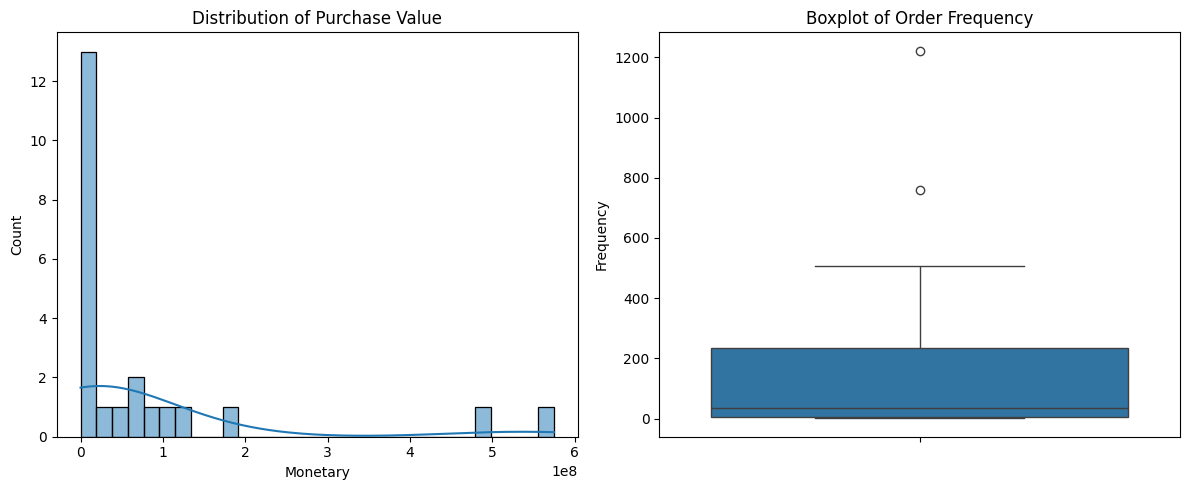

In [7]:
# 2. Histograms and Boxplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(customer_df['Monetary'], bins=30, kde=True)
plt.title('Distribution of Purchase Value')

plt.subplot(1, 2, 2)
sns.boxplot(y=customer_df['Frequency'])
plt.title('Boxplot of Order Frequency')
plt.tight_layout()
plt.show()

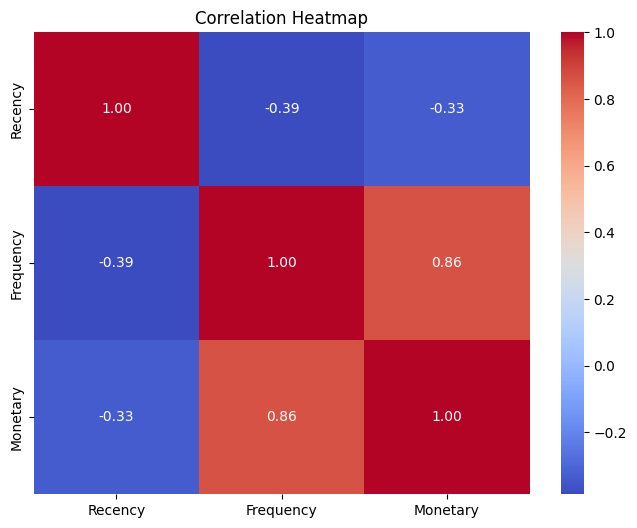


Interpretation:
1. If Frequency and Monetary are highly correlated, high-volume buyers also spend the most.
2. Recency usually has a negative correlation with Monetary (churned customers spend less recently).


In [8]:
# 3. Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = customer_df[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Interpretation (Printed to console)
print("\nInterpretation:")
print("1. If Frequency and Monetary are highly correlated, high-volume buyers also spend the most.")
print("2. Recency usually has a negative correlation with Monetary (churned customers spend less recently).")

In [9]:
# ==========================================
# PART C: Feature Engineering
# ==========================================
print("\n--- PART C: FEATURE ENGINEERING ---")

# 1. Create Loyalty Index (Composite of normalized Frequency and Monetary)
# Justification: Identifies customers who buy often AND spend a lot.
customer_df['Loyalty_Index'] = (customer_df['Frequency_Norm'] * 0.5) + (customer_df['Monetary_Norm'] * 0.5)
print("\nLoyalty Index created.")


--- PART C: FEATURE ENGINEERING ---

Loyalty Index created.


In [10]:
# 2. Create Recency Score (Inverse of Recency - Higher is better)
# Justification: Easier for models to interpret 'higher is better'.
# We use qcut to create quartiles (1 to 4, where 4 is most recent)
try:
    customer_df['Recency_Score'] = pd.qcut(customer_df['Recency'], q=4, labels=[4, 3, 2, 1]) # 4 is best (lowest days)
except ValueError:
    # Fallback if too few unique values
    customer_df['Recency_Score'] = 1 
    print("Warning: Not enough data points for qcut Recency Score.")

print("Created 'Loyalty_Index' and 'Recency_Score'.")

Created 'Loyalty_Index' and 'Recency_Score'.



--- PART D: CLUSTERING MODELLING ---


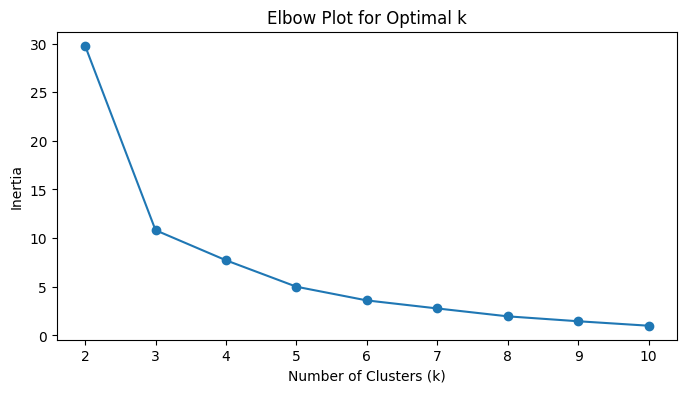

In [16]:
# ==========================================
# PART D: Clustering Modelling
# ==========================================
print("\n--- PART D: CLUSTERING MODELLING ---")

# Features for clustering
features_for_clustering = ['Recency', 'Frequency', 'Monetary']
X = customer_df[features_for_clustering]

# Standardize before K-Means (Critical for distance-based algorithms)
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

# 1. Elbow Plot
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Plot for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [12]:
# 2. Select Optimal k (Automated selection or manual choice)
# For this exam scenario, we will select k=3 or 4 based on typical e-commerce patterns
optimal_k = 4
print(f"Selected Optimal k = {optimal_k} (Based on Elbow Method interpretation)")

# Apply K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans_final.fit_predict(X_scaled)

Selected Optimal k = 4 (Based on Elbow Method interpretation)


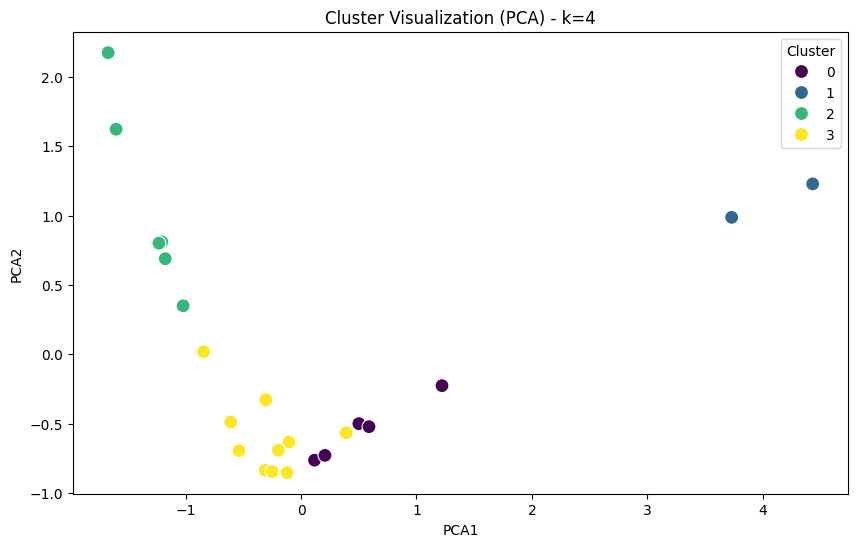

In [13]:
# 3. PCA 2D Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
customer_df['PCA1'] = pca_components[:, 0]
customer_df['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='viridis', s=100)
plt.title(f'Cluster Visualization (PCA) - k={optimal_k}')
plt.show()

In [14]:
# 4. Cluster Profile Summary
summary = customer_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Loyalty_Index']].mean()
print("\nCluster Profile Summary:")
print(summary)


Cluster Profile Summary:
           Recency   Frequency      Monetary  Loyalty_Index
Cluster                                                    
0         0.600000  301.000000  6.387138e+07       0.178404
1         0.000000  990.500000  5.360106e+08       0.871414
2        72.166667    9.666667  3.244462e+06       0.006371
3         9.500000   38.400000  3.722004e+07       0.047689


In [18]:
# ==========================================
# EXPORT FOR POWER BI (PART E)
# ==========================================
customer_df.to_csv('clustering_results_for_Nigerian.csv', index=False)